In [ ]:
#Mounting Google drive where data is stored
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
#Mounting Google drive where data is stored
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.6 MB/s 


In [ ]:
#Imports
import nibabel as nb
import tensorflow as tf
import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import imageio
import shutil
import skimage
from skimage.transform import resize
from sklearn.preprocessing import binarize
import cv2
from PIL import Image
import sys

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

TensorFlow version: 2.9.2
Keras version: 2.9.0


In [ ]:
#Main folders paths
Data_2018_path = '/content/gdrive/MyDrive/Magistera/2018'
Data_2019_path = '/content/gdrive/MyDrive/Magistera/2019'
Data_2020_path = '/content/gdrive/MyDrive/Magistera/2020'
PNG_path = '/content/gdrive/MyDrive/Magistera/PNG'
MODELS_path = '/content/gdrive/MyDrive/Magistera/MODELS'

TRAIN_path = 'TRAIN'
MASK_path = 'MASK'
VALIDATION_path = 'VALID'
MASK_VALIDATION_path = 'MASK VALID'


TRAIN_ALL_path = 'TRAIN ALL'
MASK_ALL_path = 'MASK ALL'
VALIDATION_ALL_path = 'VALID ALL'
MASK_VALIDATION_ALL_path = 'MASK VALID ALL'

IMG_path = 'IMG'


HGG_path = 'HGG'
LGG_path = 'LGG'
MICCAI_path = 'MICCAI_BraTS2020_TrainingData'

In [ ]:
def createDirs(directory, destination, PNG_path  = PNG_path):
  """
  Function is responsible for creating proper directories in PNG directory with a name of dataset (2018/2019/2022), case number and file type (t1ce/seg - ground truth)

  Args:
    directory   (string): directory in which BraTS data is stored
    destination (string): destination in which directories are going to be created
    PNG_path    (string): DEFAULT: path to PNG directory

  Returns:
    Nothing

  Raises:
    Nothing

  """
  for directory in sorted(os.listdir(directory)):
      patient_dir = os.path.join(PNG_path,destination,directory)
      if os.path.isdir(patient_dir):
        print("Directory exists")
      else:
        os.mkdir(patient_dir)

In [ ]:
def niiToPNG(directory, file_type, destination, PNG_path = PNG_path, mask=False,):
    """
    Function is responsible for saving nii.gz brain slices in PNG format in proper directories

    Args:
      directory   (string): directory in which BraTS data is stored
      file_type   (string): brain slices or ground truth mask ("_t1ce.nii.gz" or "seg.nii.gz")
      destination (string): destination in which directories are going to be created
      PNG_path    (string): DEFAULT: path to PNG directory
      mask        (bool):   DEFAULT: boolean value if processing image is mask or not

    Returns:
      Nothing

    Raises:
      Exception ("Proper directory does not exist! Create directory using createDirs function")
    """

    for dirs in sorted(os.listdir(directory)):
      data_path = os.path.join(directory,dirs)
      for files in os.listdir(data_path):
        if file_type in files:
          patient_dir = os.path.join(PNG_path,destination,dirs)
          if os.path.isdir(patient_dir):
            img = nb.load(data_path+"/"+files).get_fdata()
            (x,y,z) = img.shape
            fname = files.replace('.nii','')
            for i in range(z):
              slices = img[:,:,i]
              if os.path.isfile(os.path.join(patient_dir,'{}.png'.format(i))):
                print("PNG already saved")
              elif mask:
                im_bin = (slices > 0.26)
                im_out = (slices-im_bin+(1-im_bin))*255
                im_out = im_out.astype('int8')
                np.set_printoptions(threshold=sys.maxsize)
                Image.fromarray(np.uint8(np.invert(im_out))).save(os.path.join(patient_dir,'{}.png'.format(i)))
              else:
                imageio.imwrite(os.path.join(patient_dir,'{}.png'.format(i)), slices)
                continue
          else:
            raise Exception ("Proper directory does not exist! Create directory using createDirs function")

In [ ]:
def showSlices(directory, patient_index):
    """
    Function is responsible for ploting images in given directory of a patient with given index

    Args:
      directory   (string): directory in which PNG images are stored
      patient_index   (int):    index of the patient directory

    Returns:
      Nothing

    Raises:
      Nothing
    """
    plt.rcParams['image.cmap'] = 'gray'
    # Show a few sample digits from the training set together with their labels
    col1 = 15
    row1 = 10

    fig = plt.figure(figsize=(col1, row1))
    for root, dirs, files in os.walk(directory):
      PNG_folder_path = os.path.join(directory,dirs[patient_index])
      slices = os.listdir(PNG_folder_path)
      for index in range(0,col1*row1):
        fig.add_subplot(row1, col1, index+1)
        plt.axis('off')
        img_path = os.path.join(PNG_folder_path, slices[index])
        img = plt.imread(img_path)
        plt.imshow(img) # index of the sample image
        plt.title(slices[index])
      plt.show()
      break


In [ ]:
def createValidationFiles(inputDirectories, destination):
  """
    Function is responsible for splitting training images for trainig and validtion(4:1 ratio)

    Args:
      inputDirectories   (string): directory in which PNG images are stored
      destination        (int):    directory to which PNG images are moved

    Returns:
      Nothing

    Raises:
      Nothing
    """
  for index, directory in enumerate(sorted(os.listdir(inputDirectories))):
    if index %5 == 0:
      if os.path.isdir(os.path.join(destination,directory)):
        continue
      else:
        shutil.move(os.path.join(inputDirectories,directory),destination)


In [ ]:
def moveAllImages(directory,destination, id=0):
  """
    Function is responsible for split

    Args:
      directory   (string): directory in which PNG images are stored
      patient_index   (int):    index of the patient directory

    Returns:
      Nothing

    Raises:
      Nothing
    """
  for dirs in sorted(os.listdir(directory)):
    data_path = os.path.join(directory,dirs)
    for files in os.listdir(data_path):
      shutil.move(os.path.join(directory,data_path,files),destination+'/{}.png'.format(id))
      id+=1

In [ ]:
directory2020 = os.path.join(Data_2020_path, MICCAI_path)
# print(len(os.listdir(directory2020)))
createDirs(directory2020,TRAIN_path)
niiToPNG(directory2020,"_t1ce.nii.gz",TRAIN_path)

In [ ]:
directory2020 = os.path.join(Data_2020_path, MICCAI_path)
# print(len(os.listdir(directory2020)))
createDirs(directory2020,MASK_path)
niiToPNG(directory2020,"_seg.nii.gz",MASK_path,PNG_path)

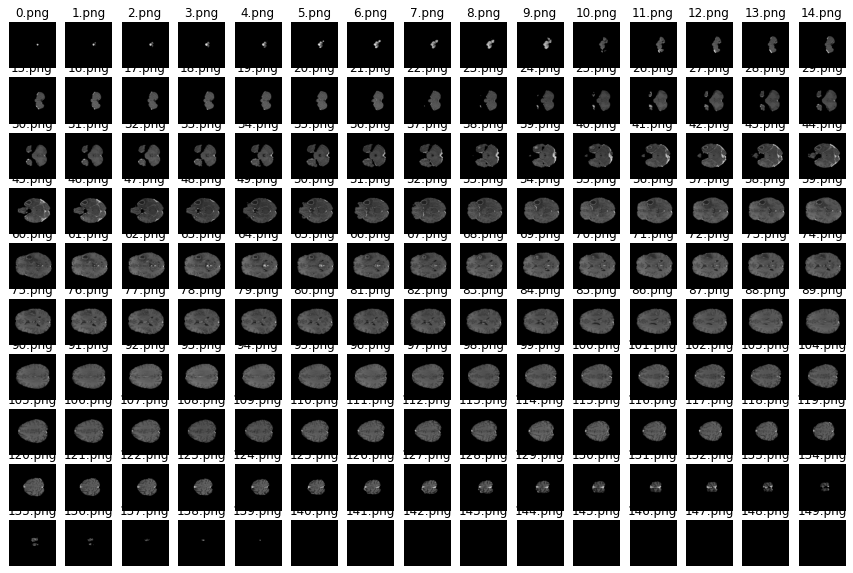

In [ ]:
directoryTrainPNG = os.path.join(PNG_path,TRAIN_path)
showSlices(directoryTrainPNG,0)

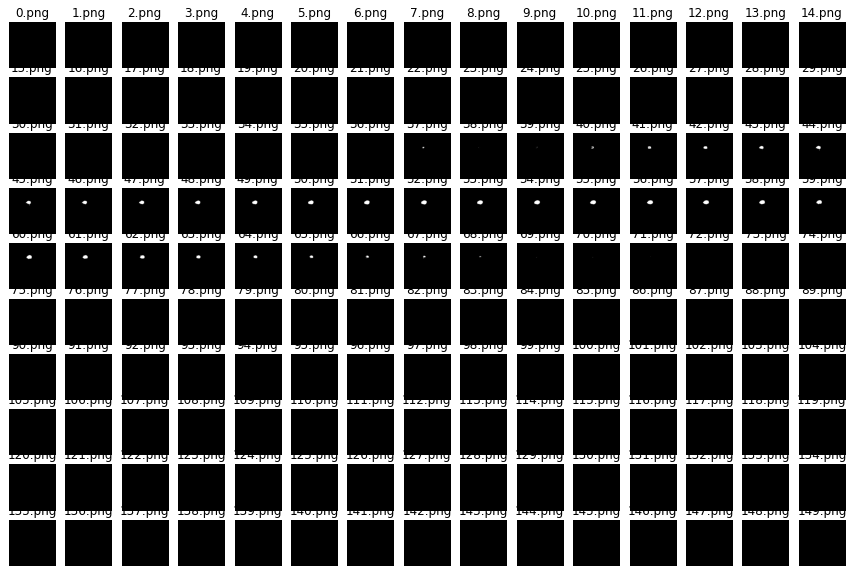

In [ ]:
directoryMaskPNG = os.path.join(PNG_path,MASK_path)
showSlices(directoryMaskPNG,0)

In [ ]:
directoryValidation = os.path.join(PNG_path,VALIDATION_path)
# createValidationFiles(directoryTrainPNG,directoryValidation)

In [ ]:
directoryMaskValidation = os.path.join(PNG_path,MASK_VALIDATION_path)
# createValidationFiles(directoryMaskPNG,directoryMaskValidation)

In [ ]:
print("Train directories: " +str(len(os.listdir(directoryTrainPNG))))
print("Validation directories: " +str(len(os.listdir(directoryValidation))))
print("Mask directories: " +str(len(os.listdir(directoryMaskPNG))))
print("Mask Validation directories: " +str(len(os.listdir(directoryMaskValidation))))

Train directories: 295
Validation directories: 74
Mask directories: 295
Mask Validation directories: 74


In [ ]:
siz = 128

In [ ]:
i=0
directoryTrainPNG = PNG_path+'/'+TRAIN_path
num_of_files= int(len(os.listdir(directoryTrainPNG))*155)
print(num_of_files)
training_MRI = np.zeros((num_of_files,siz,siz),dtype=np.float32)
print(training_MRI.shape)
for dictionary in sorted(os.listdir(directoryTrainPNG)):
    images = [image for image in os.listdir(directoryTrainPNG+'/'+dictionary) if image.endswith(".png")]
    images = sorted(images, key=lambda string: int(string.split("_")[-1][:-4]))
    for image in images:
        path = directoryTrainPNG+'/'+dictionary+'/'+image
#         print(path)
        img = plt.imread(path)
        if img is not None:
            img_arr = np.asarray(img)
            img_arr= img_arr[56:184, 56:184]
            # img_arr = resize(img_arr,(siz,siz),preserve_range=True)
#             print(np.unique(img_arr))
            training_MRI[i,:,:] = img_arr
#             print(np.unique(training_MRI[i,:,:]))
            i += 1

45725
(45725, 128, 128)


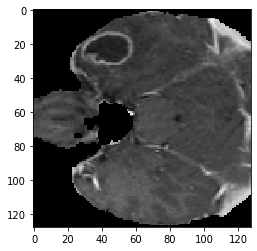

In [ ]:
del images
plt.imshow(training_MRI[45,:,:], interpolation='nearest', cmap='gray')
plt.show()

In [ ]:
i=0
directoryMaskPNG = PNG_path+'/'+MASK_path
num_of_files= int(len(os.listdir(directoryMaskPNG))*155)
print(num_of_files)
training_MASK = np.zeros((num_of_files,siz,siz),dtype=np.float32)
print(training_MRI.shape)
for dictionary in sorted(os.listdir(directoryMaskPNG)):
    images = [image for image in os.listdir(directoryMaskPNG+'/'+dictionary) if image.endswith(".png")]
    images = sorted(images, key=lambda string: int(string.split("_")[-1][:-4]))
    for image in images:
        path = directoryMaskPNG+'/'+dictionary+'/'+image
#         print(path)
        img = plt.imread(path)
        if img is not None:
            img_arr = np.asarray(img)
            img_arr= img_arr[56:184, 56:184]
            # img_arr = resize(img_arr,(siz,siz),preserve_range=True)
#             print(np.unique(img_arr))
            training_MASK[i,:,:] = img_arr
#             print(np.unique(training_MRI[i,:,:]))
            i += 1

45725
(45725, 128, 128)


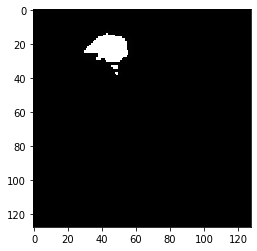

In [ ]:
plt.imshow(training_MASK[45,:,:], interpolation='nearest', cmap='gray')
plt.show()
# del images

In [ ]:
i=0
directoryValidPNG = directoryValidation
num_of_files= int(len(os.listdir(directoryValidPNG))*155)
print(num_of_files)
test_MRI = np.zeros((num_of_files,siz,siz),dtype=np.float32)
for dictionary in sorted(os.listdir(directoryValidPNG)):
    images = [image for image in os.listdir(directoryValidPNG+'/'+dictionary) if image.endswith(".png")]
    images = sorted(images, key=lambda string: int(string.split("_")[-1][:-4]))
    for image in images:
        path = directoryValidPNG+'/'+dictionary+'/'+image
#         print(path)
        img = plt.imread(path)
        if img is not None:
            img_arr = np.asarray(img)
            img_arr= img_arr[56:184, 56:184]
            # img_arr = resize(img_arr,(siz,siz),preserve_range=True)
#             print(np.unique(img_arr))
            test_MRI[i,:,:] = img_arr
            # print(np.shape(test_MRI[i,:,:]))
            i += 1

11470


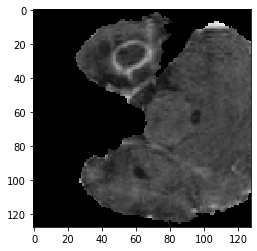

In [ ]:
plt.imshow(test_MRI[45,:,:], interpolation='nearest', cmap='gray')
plt.show()
del images

In [ ]:
i=0
directoryValidMaskPNG = directoryMaskValidation
num_of_files= int(len(os.listdir(directoryValidMaskPNG))*155)
print(num_of_files)
test_MASK = np.zeros((num_of_files,siz,siz),dtype=np.float32)
for dictionary in sorted(os.listdir(directoryValidMaskPNG)):
    images = [image for image in os.listdir(directoryValidMaskPNG+'/'+dictionary) if image.endswith(".png")]
    images = sorted(images, key=lambda string: int(string.split("_")[-1][:-4]))
    for image in images:
        path = directoryValidMaskPNG+'/'+dictionary+'/'+image
#         print(path)
        img = plt.imread(path)
        if img is not None:
            img_arr = np.asarray(img)
            img_arr= img_arr[56:184, 56:184]
            # img_arr = resize(img_arr,(siz,siz),preserve_range=True)
#             print(np.unique(img_arr))
            test_MASK[i,:,:] = img_arr
#             print(np.unique(training_MRI[i,:,:]))
            i += 1

11470


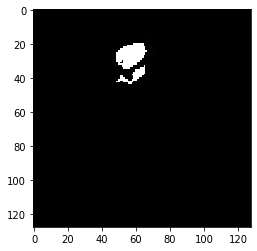

In [ ]:
plt.imshow(test_MASK[45,:,:], interpolation='nearest', cmap='gray')
plt.show()
del images

In [ ]:
import segmentation_models as sm
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
sm.set_framework('tf.keras')
BACKBONE = 'resnet34'
preprocessing_input=sm.get_preprocessing(BACKBONE)

Segmentation Models: using `keras` framework.


In [ ]:
from sklearn.model_selection import train_test_split
X = np.expand_dims(training_MRI,axis=3)
Y = np.expand_dims(training_MASK,axis=3)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2,random_state=42)

In [ ]:
del training_MRI
del training_MASK

In [ ]:
model_standard = sm.Unet(BACKBONE, encoder_weights=None,input_shape=(siz, siz, 1))
model_standard.compile(optimizer='adam',loss=bce_jaccard_loss,metrics=[iou_score])
print(model_standard.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 1)  3           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 1)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 64, 64, 64)   3136        ['zero_padding2d[0][0]']   

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint(filepath = MODELS_path+'/model_for_segmentation3.h5',verbose=1,save_best_only=True)
]

history_standard = model_standard.fit(x_train,y_train,batch_size=8,epochs=30,verbose=1, callbacks=callbacks, validation_data=(x_val,y_val))
# np.save(MODELS_path+'/my_history.npy',history_standard.history)

Epoch 1/30
4573/4573 [==============================] - ETA: 0s - loss: 0.3507 - iou_score: 0.6589
Epoch 1: val_loss improved from inf to 0.37361, saving model to /content/gdrive/MyDrive/Magistera/MODELS/model_for_segmentation3.h5
4573/4573 [==============================] - 120s 26ms/step - loss: 0.3507 - iou_score: 0.6589 - val_loss: 0.3736 - val_iou_score: 0.6373
Epoch 2/30
4571/4573 [============================>.] - ETA: 0s - loss: 0.3493 - iou_score: 0.6601
Epoch 2: val_loss did not improve from 0.37361
4573/4573 [==============================] - 117s 25ms/step - loss: 0.3493 - iou_score: 0.6601 - val_loss: 0.3746 - val_iou_score: 0.6362
Epoch 3/30
4573/4573 [==============================] - ETA: 0s - loss: 0.3527 - iou_score: 0.6568
Epoch 3: val_loss improved from 0.37361 to 0.37355, saving model to /content/gdrive/MyDrive/Magistera/MODELS/model_for_segmentation3.h5
4573/4573 [==============================] - 119s 26ms/step - loss: 0.3527 - iou_score: 0.6568 - val_loss: 0.373

In [ ]:
model_standard = keras.models.load_model(MODELS_path+'/model_for_segmentation3.h5',custom_objects={'binary_crossentropy_plus_jaccard_loss':
bce_jaccard_loss,'iou_score':iou_score})

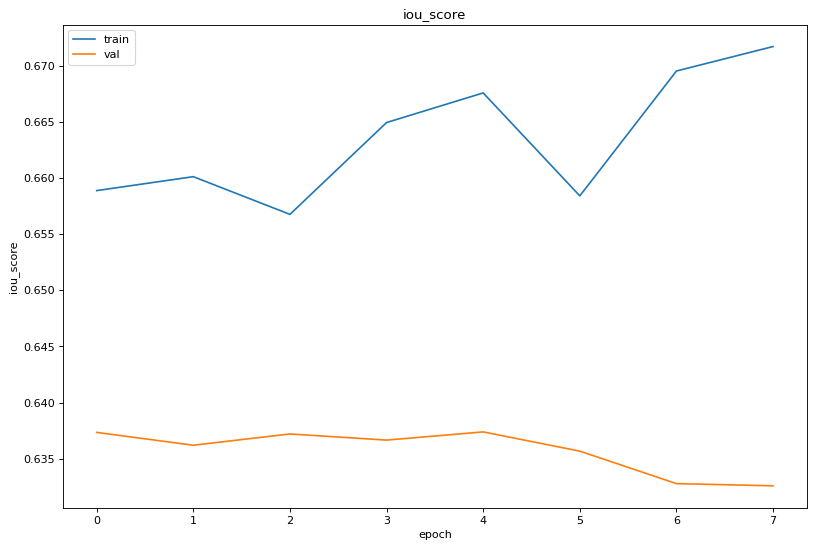

In [ ]:
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(history_standard.history['iou_score'])
plt.plot(history_standard.history['val_iou_score'])
plt.title('iou_score')
plt.ylabel('iou_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

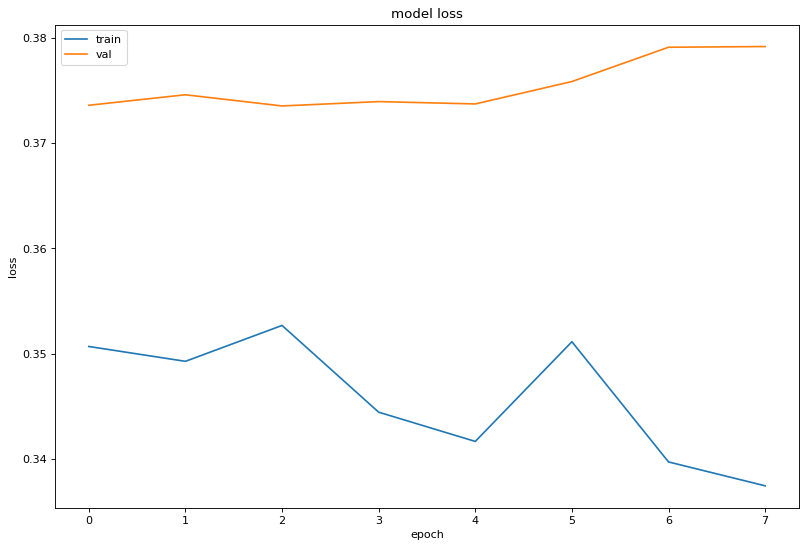

In [ ]:
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(history_standard.history['loss'])
plt.plot(history_standard.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
history=np.load(MODELS_path+'/my_history.npy',allow_pickle='TRUE').item()

history['iou_score'] += history_standard.history['iou_score']
history['val_iou_score'] += history_standard.history['val_iou_score']
history['loss'] += history_standard.history['loss']
history['val_loss'] += history_standard.history['val_loss']

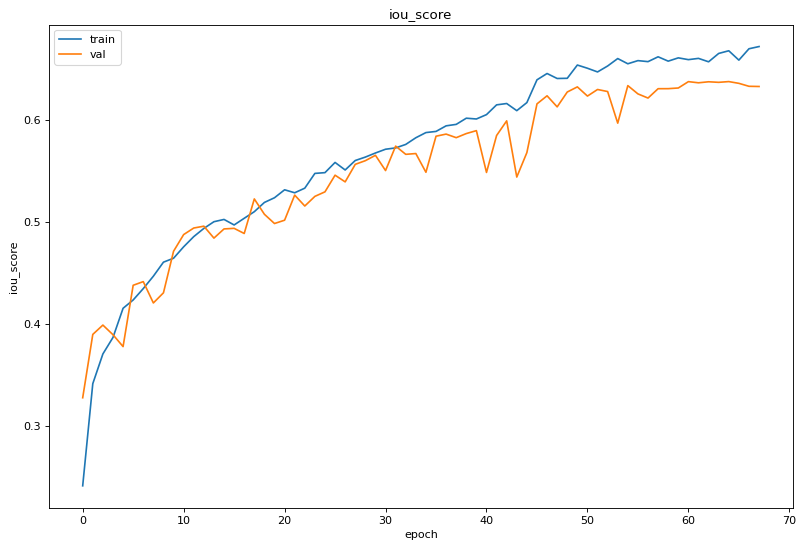

In [ ]:
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(history['iou_score'])
plt.plot(history['val_iou_score'])
plt.title('iou_score')
plt.ylabel('iou_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

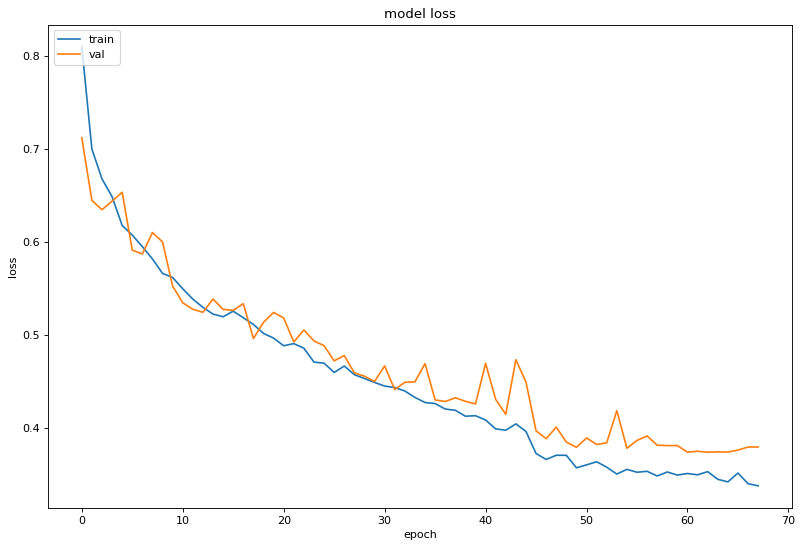

In [ ]:
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
np.save(MODELS_path+'/my_history.npy',history)

In [ ]:
del training_MRI
del training_MASK

In [ ]:
preds_train_standard = model_standard.predict(test_MRI,verbose=1)

359/359 [==============================] - 3s 9ms/step


In [ ]:
test_MRI=np.expand_dims(test_MRI,axis=3)
test_MASK=np.expand_dims(test_MASK,axis=3)

eva_standard = model_standard.evaluate(test_MRI,test_MASK)

359/359 [==============================] - 4s 11ms/step - loss: 0.9048 - iou_score: 0.1531


In [ ]:
print(preds_train_standard.shape)
preds_train_standard2 = preds_train_standard[:,:,:,0]

print(preds_train_standard2.shape)

(11470, 128, 128, 1)
(11470, 128, 128)


In [ ]:
preds_train_standard2 = preds_train_standard2 > 0.5
print(len(np.unique(preds_train_standard2[65,:,:])))

2


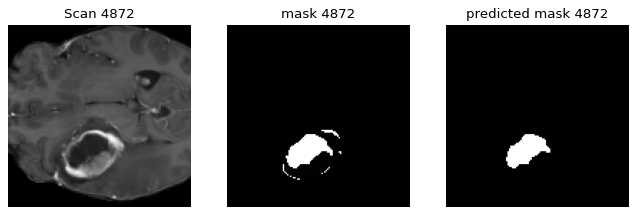

In [ ]:
import random
x=random.randint(0,int(len(os.listdir(directoryValidMaskPNG))*155))
# x=850
plt.figure(figsize=(10, 6), dpi=80)
plt.subplot(1,3,1)
plt.title(f'Scan {x}')
plt.axis('off')
plt.imshow(test_MRI[x,:,:,0],cmap = 'gray')
plt.subplot(1,3,2)
plt.title(f'mask {x}')
plt.axis('off')
plt.imshow(test_MASK[x,:,:,0],cmap = 'gray')
plt.subplot(1,3,3)
plt.title(f'predicted mask {x}')
plt.axis('off')
plt.imshow(preds_train_standard2[x,:,],cmap = 'gray')

In [ ]:
from keras.metrics import MeanIoU
num_classes = 2
IOU_keras = MeanIoU(num_classes=num_classes)
IOU_keras.update_state(test_MASK[x,:,:,0],preds_train_standard2[x,:,])
print("Mean IoU = ",IOU_keras.result().numpy())

Mean IoU =  0.92953384
